# Mortgage Approval Prediction

### Contents
- [Authentication](#tokens)
- [Import Libraries](#libraries)
- [Setup AI Factsheets](#factsheet)
- [Load training data](#data)
- [Specify User Inputs](#userinputs)
- [Build Data Pipelines](#transformers)
- [Build Machine Learning Models](#ml)
- [View Model Results](#results)
- [Save the model](#save)

### Authentication  <a name="tokens"></a>
Enter hostname, username and password.

In [3]:
import getpass

hostname=input("Enter host name: ")


username = input("Username: ")
pwd = getpass.getpass("Password for " + username + ":")

catalog_name = input("Enter catalog name")

You can then step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell > Run All** from the menu.<br>

### Import Libraries  <a name="libraries"></a>

This cell imports the python libraries that you will use throughout the notebook. 
`matplotlib` and `seaborn` libraries are used to visualize the data. The code uses the `sklearn` library to build transformers and machine learning models. 

In [2]:


try:
    from ibm_aigov_facts_client import AIGovFactsClient,CloudPakforDataConfig
except:
    !pip install -U ibm-aigov-facts-client
    from ibm_aigov_facts_client import AIGovFactsClient
        
from ibm_aigov_facts_client import AIGovFactsClient,CloudPakforDataConfig

from ibm_aigov_facts_client.supporting_classes.factsheet_utils import DeploymentDetails,TrainingDataReference,ExternalModelSchemas

import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import requests
s=requests.session()
import json

import random
import seaborn as sns
sns.set(style='darkgrid',palette="deep")

import ibm_db, ibm_db_dbi as dbi


from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import string
from sklearn import metrics
import project_lib
project = project_lib.Project() 
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()
!pip install ibm-cloud-sdk-core

### Set up AI Factsheets  <a name="factsheet"></a>

[AI Factsheets](https://aifs360.res.ibm.com/) will be used to track the lifecycle of the model built using sci-kit library. This cell imports the AI Factsheets client and creates an experiment to log the results to AI Factsheets. Restart the kernal after installing the below libraries.

In [4]:
cpd_creds=CloudPakforDataConfig(service_url=hostname,username=username,password=pwd)

PROJECT_UID= os.environ['PROJECT_ID'] #this assumes you are running in Studio. When running externally please add the project id here.
CPD_URL=os.environ['RUNTIME_ENV_APSX_URL']
CONTAINER_ID=PROJECT_UID
CONTAINER_TYPE='project'
EXPERIMENT_NAME='mortgage_approval_prediction'


In [5]:
try:
    facts_client = AIGovFactsClient(experiment_name=EXPERIMENT_NAME,container_type=CONTAINER_TYPE,container_id=CONTAINER_ID,cloud_pak_for_data_configs=cpd_creds)
except:
    print("Experiment Name",EXPERIMENT_NAME+"100","already exists.")
    
    EXPERIMENT_NAME = EXPERIMENT_NAME + '_'+''.join(random.choice(string.ascii_lowercase + string.digits) for _ in range(3))
    print("Creating a new experiment with name -",EXPERIMENT_NAME)
    facts_client = AIGovFactsClient(experiment_name=EXPERIMENT_NAME,container_type=CONTAINER_TYPE,container_id=CONTAINER_ID,cloud_pak_for_data_configs=cpd_creds)
    
    
    
    

    

2023/10/16 11:58:20 INFO : Experiment successfully created with ID 1 and name mortgage_approval_prediction
2023/10/16 11:58:20 INFO : Autolog enabled Successfully


### Connect to a Database 

In [6]:
DATABASE_CREDENTIALS=project.get_connection(name="Data Fabric Trial - Db2 Warehouse")

In [7]:
db2_warehouse_datafabric_trial_dsn = 'DATABASE={};HOSTNAME={};PORT={};PROTOCOL=TCPIP;UID={uid};PWD={pwd};SECURITY=SSL'.format(DATABASE_CREDENTIALS['database'],DATABASE_CREDENTIALS['host'],DATABASE_CREDENTIALS['port'],uid=DATABASE_CREDENTIALS['username'],pwd=DATABASE_CREDENTIALS['password'])

db2_warehouse_datafabric_trial_connection = dbi.connect(db2_warehouse_datafabric_trial_dsn)
   

#### SQL Query to read the tables
The SQL Query below returns the raw data required to train the model.

In [9]:
sql_query='select * from AI_MORTGAGE.MORTGAGE_APPROVAL_VIEW'


### Load  training data   <a name="data"></a>

Load the received data into a Pandas dataframe.

In [10]:
df_mortgage = pd.read_sql_query(sql_query, con=db2_warehouse_datafabric_trial_connection)

df_mortgage.head()

/tmp/1000680000/ipykernel_214/1025671169.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_mortgage = pd.read_sql_query(sql_query, con=db2_warehouse_datafabric_trial_connection)


,ID,NAME,STREET_ADDRESS,CITY,STATE,STATE_CODE,ZIP_CODE,EMAIL_ADDRESS,PHONE_NUMBER,GENDER,SOCIAL_SECURITY_NUMBER,EDUCATION,EMPLOYMENT_STATUS,MARITAL_STATUS,INCOME,APPLIEDONLINE,RESIDENCE,YRS_AT_CURRENT_ADDRESS,YRS_WITH_CURRENT_EMPLOYER,NUMBER_OF_CARDS,CREDITCARD_DEBT,LOANS,LOAN_AMOUNT,CREDIT_SCORE,COMMERCIAL_CLIENT,COMM_FRAUD_INV,PROPERTY_VALUE,AREA_AVG_PRICE,MORTGAGE_APPROVAL
0,110424,Adah Marks,4355-5 Pelham South,Park Ridge,Illinois,IL,41227,Adah.Marks@donny.ca,206-220-3128,Male,403-49-3266,College,Employed,Married,49051.0,YES,Owner Occupier,11,12,2,1168.0,1,7478.0,547,FALSE,FALSE,548618.0,NaN,0
1,110425,Jerrell Eichmann,5642-1 Hwy 78 East,Reston,Virginia,VA,41198,Jerrell.Eichmann@trycia.biz,972-510-7295,Male,394-17-0450,High School or Below,Unemployed,Married,49052.0,YES,Owner Occupier,11,12,2,1167.0,1,7476.0,547,TRUE,FALSE,548638.0,NaN,0
2,110426,Glennie Barrows,6736-1 Whitfield Ave,Houston,Texas,TX,41169,Glennie.Barrows@elwin.us,609-564-9894,Female,295-29-1540,High School or Below,Employed,Married,49053.0,YES,Owner Occupier,11,12,2,1166.0,1,7474.0,547,FALSE,FALSE,548658.0,NaN,0
3,110427,Susanna Schaefer,4529-0 Madison Blvd,Woodridge,Illinois,IL,41140,Susanna.Schaefer@elta.ca,484-261-6798,Female,204-81-0296,Bachelor,Employed,Married,49054.0,YES,Public Housing,11,12,2,1165.0,1,7471.0,547,FALSE,FALSE,548678.0,NaN,0
4,110428,Jettie Waters,3698-Kelley Blvd,Truckee,California,CA,41110,Jettie.Waters@kacie.co.uk,253-973-4793,Male,161-55-7466,College,Unemployed,Single,49054.0,YES,Living with parents/guardian,11,12,2,1164.0,1,7469.0,546,TRUE,FALSE,548698.0,721244.0,0


In [11]:
project.save_data("MORTGAGE_APPROVAL_VIEW.csv",df_mortgage.to_csv(),overwrite=True)

{'file_name': 'MORTGAGE_APPROVAL_VIEW.csv',
 'message': 'File saved to project storage.',
 'asset_id': '12d50598-c135-4a90-9d5d-b96be0aa1315'}

### Specify User Inputs <a name="userinputs"></a>

These user inputs are defined in the cell below.

**target_col :** This is the target column indicating whether a mortgage application is approved or not.<br>
**categorical_cols :** A list of all categorical variables that need to be transformed before input into the model. You will use a transformer to impute missing values and create dummy variables.<br>
**numerical_cols :** A list of all of the numerical features that you input into the model. Later in the code, you use a transformer to impute any missing values in these columns. Flag like variables, with values of either 1 or 0 are included in this list.<br>
**cat_pct :** A threshold that defines the percentage of unique values in a categorical feature that is acceptable for one-hot encoding.<br>
**cor_pct :** A threshold that defines the level of correlation, at which point a feature needs to be removed from analysis.<br>


If the data scientist is using their own data, they can easily update the variables below to point at their own specific column names.

All of these variables are stored in a dictionary which is saved as part of the metadata when deploying the pipeline in the deployment space. you store this dictionary so that the same user inputs can be applied when scoring new data.

In [12]:
numerical_cols=['INCOME','YRS_AT_CURRENT_ADDRESS','YRS_WITH_CURRENT_EMPLOYER','NUMBER_OF_CARDS','CREDITCARD_DEBT','LOAN_AMOUNT','CREDIT_SCORE','PROPERTY_VALUE','AREA_AVG_PRICE','LOANS']
target_col='MORTGAGE_APPROVAL'
categorical_cols=['STATE','GENDER','EDUCATION','EMPLOYMENT_STATUS','MARITAL_STATUS','APPLIEDONLINE','RESIDENCE','COMMERCIAL_CLIENT','COMM_FRAUD_INV']


cat_pct = 0.04
cor_pct = 0.90

In [13]:
df_prep=df_mortgage[numerical_cols+[target_col]+categorical_cols].copy()

#### Handle categorical variables
Categorical variables with a high number of unique values can significantly impact performance, because they may add too many one-hot encoded features to the dataset. Such categorical variables need to be removed.

In [14]:
for col in categorical_cols:
    if df_prep[col].nunique() > (cat_pct*df_prep.shape[0]):
        print(col,"removed")
        categorical_cols.remove(col)
        df_prep=df_prep.drop(col,axis=1)

STATE removed


Also remove the columns which have only one single category for all the rows.

In [15]:
for col in categorical_cols:
    if df_prep[col].nunique() ==1:
        print(col,"removed")
        categorical_cols.remove(col)
        df_prep=df_prep.drop(col,axis=1)

Training Data

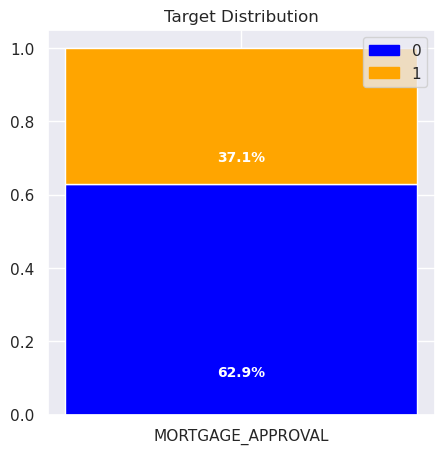

In [16]:

df_temp = df_prep[target_col].value_counts().reset_index()
df_temp['perc'] = df_temp[target_col] / df_temp[target_col].sum()

target_0 = df_temp[df_temp['index']==0]['perc'].values[0]
target_1 = df_temp[df_temp['index']==1]['perc'].values[0]

fig1, ax1 = plt.subplots(figsize=(5,5))

ax1.bar(target_col, target_0, label=target_0, color='blue')
ax1.bar(target_col, target_1, bottom=target_0, color='orange')

red_patch = mpatches.Patch(color='orange', label='1')
blue_patch = mpatches.Patch(color='blue', label='0')

plt.legend(handles=[blue_patch, red_patch], loc='best')

plt.title('Target Distribution')

for patch in ax1.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height())
    x = patch.get_x() + patch.get_width()/2
    y = patch.get_y() + patch.get_height()/6
    ax1.annotate(percentage, (x, y), ha='center', color='white', weight='bold', fontsize=10)

#### Correlation
You will carry out a correlation analysis on all variables specified in numerical_cols.

From the result of the analysis, you can see that there is no significant correlation between the columns. 

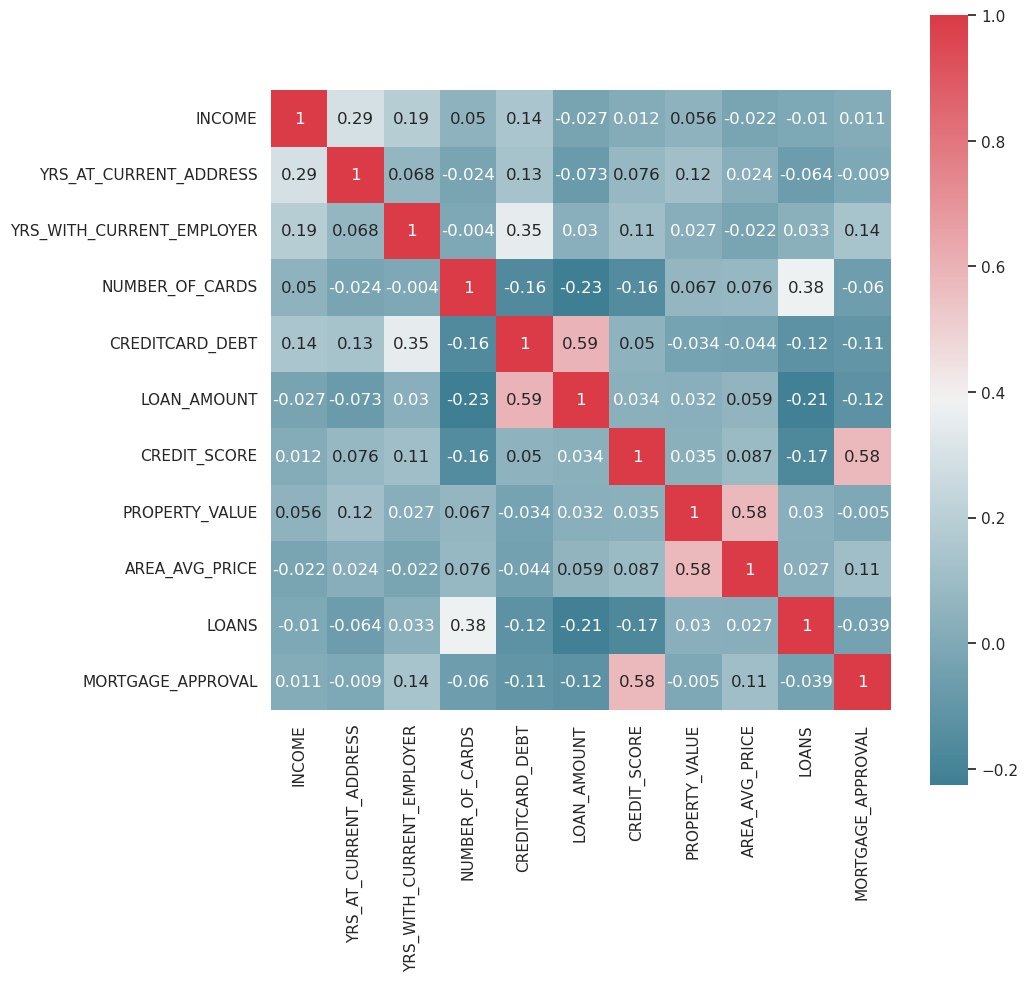

In [17]:
# check correlation between numerical features
f, ax = plt.subplots(figsize=(10, 10))
corr = df_prep[numerical_cols + [target_col]].corr()
corr = corr.round(3)
temp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax,annot=True)

#### Handle correlations
Correlated data poses the threat of disproportionately reporting the effects of features with relatively similarly. This cell removes highly correlated columns, if any.

In [18]:
corr = corr.abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] >= cor_pct)]

df_prep = df_prep.drop(to_drop, axis=1)

if(len(to_drop)>0):
    numerical_cols.remove(to_drop[0])
    print(to_drop,"Removed because of high correlation")

### Build Data Pipelines  <a name="transformers"></a>
#### Split Data and Build Transformer


The data needs to be split into training, validation and test sets. You will be using 80% of the data for training, and the remaining 20% for testing. At this point, you will also be removing records with missing values for the target variable. 

You build the models on the training set, carry out hyperparameter tuning on the test set and finally apply the selected final model. Sci-kit learn's transformers will be leveraged to process and prepare the data.


In [19]:
X = df_prep.dropna(axis=0, subset=[target_col]).drop([target_col], axis=1)
y = df_prep.dropna(axis=0, subset=[target_col])[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)


For categorical variables,a 2 step pipeline is created. The `SimpleImputer` transformer will fill in missing values with 'Other', while the `OneHotEncoder` transformer will create dummy variables for each category. The transformers are applied to the features specified in the `categorical_cols` variable.

For `numerical_cols`variables the pipeline has a single step in our example. You again leverage the `SimpleImputer` transformer to fill in missing values.



In [20]:
categorical_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='constant', fill_value='Other')), ('dummy_vars', OneHotEncoder(handle_unknown='ignore'))])
# fill in missing data - you use median to keep the 1, 0  'flag' like variables either 1 or 0
numeric_transformer = Pipeline(steps=[('impute_missing', SimpleImputer(strategy='median'))])

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
            ])

Once the transformers are combined, you perform a fit using the training data and transform the training, validation and test data. The transformer is saved out as a joblib object. It can be imported and used again when preparing new data for scoring. The feature names of the combined transformers are retrieved and stored in a list `numerical_cols`. This list is used for labelling the feature importance of the final model.

In [22]:
fitted_preprocessor = preprocessor.fit(X_train)

X_train_postprocess = fitted_preprocessor.transform(X_train)

X_test_postprocess = preprocessor.transform(X_test)

In [23]:
onehot_columns=list(fitted_preprocessor.named_transformers_['cat'].named_steps['dummy_vars'].get_feature_names_out(input_features=categorical_cols))
numeric_features_list = list(numerical_cols)
numeric_features_list.extend(onehot_columns)

### Building Machine Learning Models <a name="ml"></a>

#### Model Hyperparameter Tuning and Model Selection

A Random Forest Model will be used for this tutorial, and that will require some hyperparameter tuning. The hyperparameter selection which performs best on the imbalanced validation data is selected as final. To determine this, you will be using ROC AUC as the evaluation metric.

In [24]:
l_ne = [10, 50]
l_md = [5,7, 10] 
l_mf = [0.75, 0.9]

highest_test_auc = 0.0
top_ne = 0
top_md = 0
top_mf = 0.0

for ne in l_ne:
    for md in l_md:
        for mf in l_mf:
            clf = RandomForestClassifier(n_estimators=ne, max_depth=md, max_features=mf, random_state=0)
            clf.fit(X_train_postprocess, y_train)
            
            y_pred_train = clf.predict_proba(X_train_postprocess)[:,1]
            y_pred_test = clf.predict_proba(X_test_postprocess)[:,1]
            
            fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)
            fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)

            auc_test = metrics.auc(fpr_test, tpr_test)
            auc_train = metrics.auc(fpr_train, tpr_train)
            
            if auc_test > highest_test_auc:
                print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Test AUC :' + str(np.round(auc_test, 3)) + ' from ' + str(ne) + ' estimators, ' + str(md) + ' max depth and ' + str(mf) + ' max features***')
                top_ne = ne
                top_md = md
                top_mf = mf
                highest_test_auc = auc_test
            else:
                print('Training AUC : ' + str(np.round(auc_train, 3)) + ', Test AUC :' + str(np.round(auc_test, 3)) + ' from ' + str(ne) + ' estimators, ' + str(md) + ' max depth and ' + str(mf) + ' max features')
                

2023/10/16 11:58:25 INFO : logging results to factsheet for run_id 2219b31d93df4af9874f340595611152
2023/10/16 11:58:25 INFO : Successfully logged results to Factsheet service for run_id 2219b31d93df4af9874f340595611152 under asset_id: c3323596-22d2-42e2-ace7-0373d1a8ea7d and project_id : c36314de-78f3-42e9-9617-31669038b966
Training AUC : 0.998, Test AUC :0.967 from 10 estimators, 5 max depth and 0.75 max features***
2023/10/16 11:58:26 INFO : logging results to factsheet for run_id 456efa9a1edb40579270ceacac33063e
2023/10/16 11:58:27 INFO : Successfully logged results to Factsheet service for run_id 456efa9a1edb40579270ceacac33063e under asset_id: c3323596-22d2-42e2-ace7-0373d1a8ea7d and project_id : c36314de-78f3-42e9-9617-31669038b966
Training AUC : 0.997, Test AUC :0.969 from 10 estimators, 5 max depth and 0.9 max features***
2023/10/16 11:58:28 INFO : logging results to factsheet for run_id 584f7e36e4cf437ab4924c2fc91e0998
2023/10/16 11:58:28 INFO : Successfully logged results to

### Build Final Model 

After finding the best performing hyperparameter combination, you apply them to our final model. The model is built using training data and then evaluated using validation data. The final model and results are logged into the factsheet experiment.

In [25]:
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', RandomForestClassifier(n_estimators=top_ne, max_depth=top_md, max_features=top_mf, random_state=0))])

clf=model_pipeline.fit(X_train, y_train)
y_pred_train=model_pipeline.predict(X_train)
y_pred_test=model_pipeline.predict(X_test)

y_pred_train = model_pipeline.predict_proba(X_train)[:,1]
#y_pred_validation = model_pipeline.predict_proba(X_validation)[:,1]
y_pred_test = model_pipeline.predict_proba(X_test)[:,1]



fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)
#fpr_validation, tpr_validation, thresholds_validation = metrics.roc_curve(y_validation, y_pred_validation)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_pred_test)

auc_train = metrics.auc(fpr_train, tpr_train)
#auc_validation = metrics.auc(fpr_validation, tpr_validation)
auc_test = metrics.auc(fpr_test, tpr_test)

print('Training AUC : ' + str(np.round(auc_train, 3)) +  ' and Test AUC :' + str(np.round(auc_test, 3)) + ' from ' + str(top_ne) + ' estimators, ' + str(top_md) + ' max depth and ' + str(top_mf) + ' max features')



2023/10/16 11:58:45 INFO : logging results to factsheet for run_id a807395f99924365ac33885fd5d5b6ac
2023/10/16 11:58:46 INFO : Successfully logged results to Factsheet service for run_id a807395f99924365ac33885fd5d5b6ac under asset_id: c3323596-22d2-42e2-ace7-0373d1a8ea7d and project_id : c36314de-78f3-42e9-9617-31669038b966
Training AUC : 1.0 and Test AUC :0.978 from 50 estimators, 7 max depth and 0.9 max features


### View Model Results <a name="results"></a>

First you'll look at the plot of the ROC curve since you used area under the ROC curve (AUC) as the model evaluation metric. The ROC curve is a plot of the true positive rate `(Sensitivity)` and false positive rate `(Specificity)`. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold.

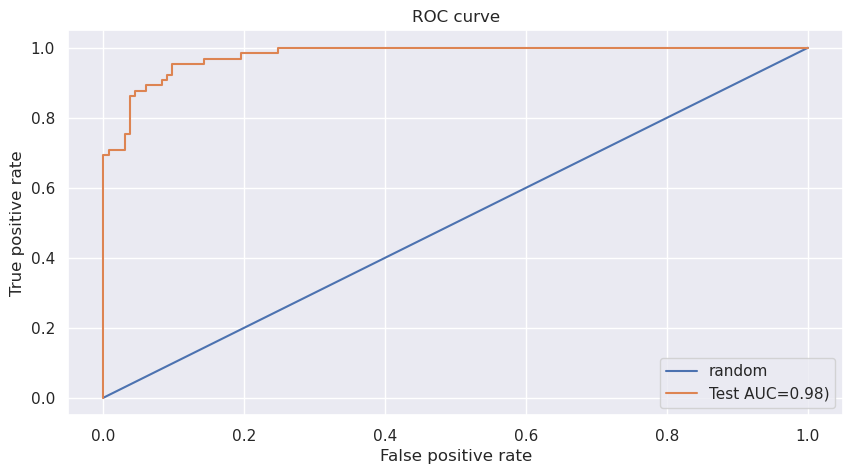

In [26]:
fig = plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], label='random')

#plt.plot(fpr_validation, tpr_validation, label= 'Validation AUC=' + str(np.round(auc_test, 2)) + ')')
plt.plot(fpr_test, tpr_test, label= 'Test AUC=' + str(np.round(auc_test, 2)) + ')')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

In [27]:
# get the optimal threshold based on Youden's index
idx_opt_thres = np.argmax(tpr_test - fpr_test)
opt_threshold = thresholds_test[idx_opt_thres]
print(opt_threshold)
y_pred_class_test = y_pred_test >= opt_threshold
y_pred_class_test = y_pred_class_test.astype(int)
#y_pred_class_test = y_pred_test >= opt_threshold
#y_pred_class_test = y_pred_test.astype(int)

0.33494044955995816


You'll next look at the confusion matrices for the validation and test results at the threshold selected above. At this threshold the classifier does a good job at correctly predicting those who readmit or not. However, it also misclassifies quite a few customers as who are approved of loan as not approved (False Positives). This result may not be sufficient to the Bank. Based on this, the analyst may want to change the threshold by reducing the false positive rate (as commented out above). Doing this does result in a trade off and the number of true positives (individuals that will truly default on their loans) would reduce. 

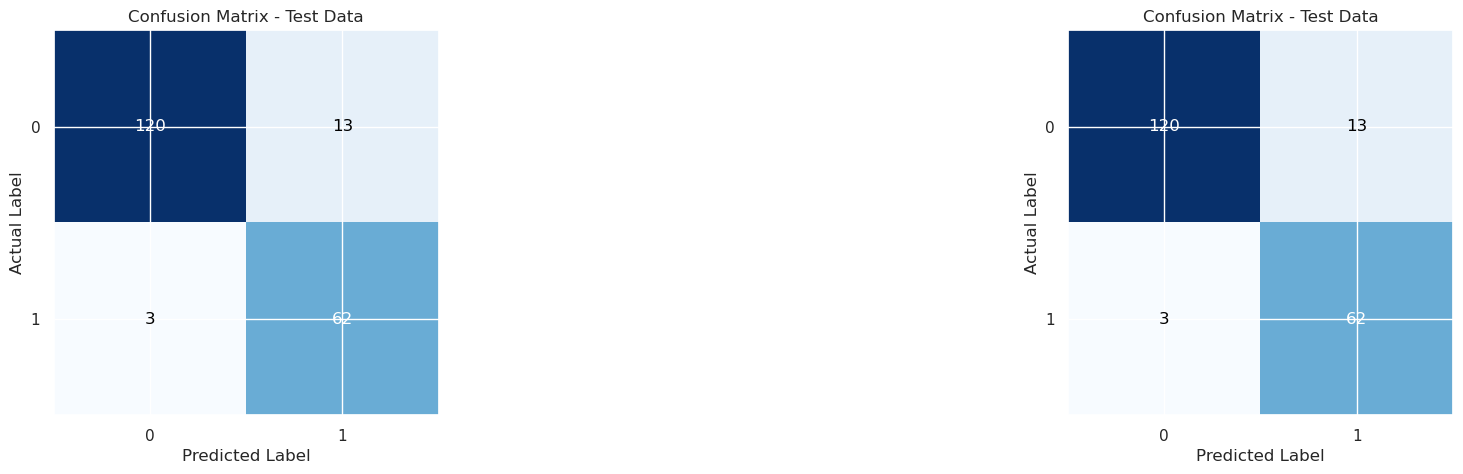

In [28]:
confusion_matrix_validation = metrics.confusion_matrix(y_test, y_pred_class_test, labels=[0,1])
confusion_matrix_test = metrics.confusion_matrix(y_test, y_pred_class_test, labels=[0,1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 5))

ax1.imshow(confusion_matrix_validation, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Confusion Matrix - Test Data')
tick_marks = np.arange(2)
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_ylabel('Actual Label')
ax1.set_xlabel('Predicted Label')
# iterate through the confusion matrix array with indexing, use this to plot counts on the chart
cm_iterator = np.nditer(confusion_matrix_validation, flags=['multi_index'])
while not cm_iterator.finished:
    num_occurances = cm_iterator[0]
    y = cm_iterator.multi_index[0]
    x = cm_iterator.multi_index[1]
    ax1.text(x, y, num_occurances, color="white" if confusion_matrix_validation[x, y] > confusion_matrix_validation.max()/2 else "black", ha='center', va='center')
    cm_iterator.iternext()

ax2.imshow(confusion_matrix_test, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('Confusion Matrix - Test Data')
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_ylabel('Actual Label')
ax2.set_xlabel('Predicted Label')
# iterate through the confusion matrix array with indexing, use this to plot counts on the chart
cm_iterator = np.nditer(confusion_matrix_test, flags=['multi_index'])
while not cm_iterator.finished:
    num_occurances = cm_iterator[0]
    y = cm_iterator.multi_index[0]
    x = cm_iterator.multi_index[1]
    ax2.text(x, y, num_occurances, color="white" if confusion_matrix_test[x, y] > confusion_matrix_test.max()/2 else "black", ha='center', va='center')
    cm_iterator.iternext()

### Save the Model <a name="save"></a>

You select the top performing model pipeline. In the next steps, you save the model pipeline along with metadata information in the project using [ibm-watson-machine-learning](https://ibm.github.io/watson-machine-learning-sdk/) client.




#### User Inputs

The user can specify the name for the model below.  <br>


In [29]:

model_name = 'Mortgage Approval Prediction Model with custom facts'


This cell imports `ibm_watson_machine_learning` library and then creates a wml client using the credentials provided.

In [30]:

from ibm_watson_machine_learning import APIClient


token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "4.8"
}

client = APIClient(wml_credentials)

Set the current project as the default project to save the model.

In [31]:
PROJECT_UID=os.environ['PROJECT_ID']


In [32]:

client.set.default_project(PROJECT_UID)

'SUCCESS'

#### Storing Pipeline Details

Storing the model requires us to curate and specify some properties:</br>
• The name for the pipeline as specified above </br>
• Training data reference, that points to the data used to train the model.</br>
• The Software Specification, that refers to the runtime used in this Notebook and the WML deployment. You use the software specification `runtime-22.2-py3.10` to store the models.</br>

In [33]:
fields=X_train.columns.tolist()
metadata_dict = {'target_col' : target_col, 'probability_threshold' : opt_threshold, 'numeric_features_list':numeric_features_list,'fields':fields,'categorical_cols':categorical_cols}


In [34]:
connection_details = client.connections.get_details()
conn_detail = connection_details['resources'][0]
connection_id = client.connections.get_uid(conn_detail)

training_data_references = [
                {
                    "id": "Mortgage_data",
                    "type": "connection_asset",
                    "connection": {
                        "id": connection_id,
                    },
                    "location": {
                        "select_statement": sql_query,
                        "table_name": "Mortgage_Approval_view"
                    }
                }]


In [35]:
software_spec_uid = client.software_specifications.get_id_by_name("runtime-22.2-py3.10")
print("Software Specification ID: {}".format(software_spec_uid))

model_props = {
        client._models.ConfigurationMetaNames.NAME:model_name,
        client._models.ConfigurationMetaNames.TYPE: "scikit-learn_1.1",
        client._models.ConfigurationMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
        client._models.ConfigurationMetaNames.LABEL_FIELD:"MORTGAGE_APPROVAL",
        client._models.ConfigurationMetaNames.INPUT_DATA_SCHEMA:[{'id': '1', 'type': 'struct', 'fields': [{"name":column_name,"type":str(column_type[0])} for column_name,column_type in pd.DataFrame(X_train.dtypes).T.to_dict('list').items()]}],
        client._models.ConfigurationMetaNames.TAGS: ['mortgage_prediction_pipeline_tag'],
        client.repository.ModelMetaNames.TRAINING_DATA_REFERENCES: training_data_references,
        client._models.ConfigurationMetaNames.CUSTOM: metadata_dict
    }

facts_client.export_facts.prepare_model_meta(wml_client=client,meta_props=model_props)


Software Specification ID: b56101f1-309d-549b-a849-eaa63f77b2fb


{'name': 'Mortgage Approval Prediction Model with custom facts',
 'type': 'scikit-learn_1.1',
 'software_spec': 'b56101f1-309d-549b-a849-eaa63f77b2fb',
 'label_column': 'MORTGAGE_APPROVAL',
 'inputDataSchema': [{'id': '1',
   'type': 'struct',
   'fields': [{'name': 'INCOME', 'type': 'float64'},
    {'name': 'YRS_AT_CURRENT_ADDRESS', 'type': 'int64'},
    {'name': 'YRS_WITH_CURRENT_EMPLOYER', 'type': 'int64'},
    {'name': 'NUMBER_OF_CARDS', 'type': 'int64'},
    {'name': 'CREDITCARD_DEBT', 'type': 'float64'},
    {'name': 'LOAN_AMOUNT', 'type': 'float64'},
    {'name': 'CREDIT_SCORE', 'type': 'int64'},
    {'name': 'PROPERTY_VALUE', 'type': 'float64'},
    {'name': 'AREA_AVG_PRICE', 'type': 'float64'},
    {'name': 'LOANS', 'type': 'int64'},
    {'name': 'GENDER', 'type': 'object'},
    {'name': 'EDUCATION', 'type': 'object'},
    {'name': 'EMPLOYMENT_STATUS', 'type': 'object'},
    {'name': 'MARITAL_STATUS', 'type': 'object'},
    {'name': 'APPLIEDONLINE', 'type': 'object'},
    {'na

The cell below exports all the facts captured by the AI Factsheets client, in addition some Notebook metadata 

In [36]:
#Defining Notebook URL
nb_name = "1-model-training-with-factsheets"
for i in project.get_assets():
    if nb_name in i['name']:
        nb_asset_id=i['asset_id']
nb_asset_url =  CPD_URL + "/analytics/notebooks/v2/" + nb_asset_id + "?projectid=" + PROJECT_UID + "&context=icp4data"

latestRunId = facts_client.runs.list_runs_by_experiment(facts_client.experiments.get_current_experiment_id()).sort_values('start_time').iloc[-1]['run_id']
facts_client.runs.set_tags(latestRunId, {"Notebook name": nb_name, "Notebook id": nb_asset_id, "Notebook URL" : nb_asset_url})
facts_client.export_facts.export_payload(latestRunId)

2023/10/16 11:58:49 INFO : Initiating logging to factsheet for run_id......a807395f99924365ac33885fd5d5b6ac
2023/10/16 11:58:50 INFO : Successfully logged results to Factsheet service for run_id a807395f99924365ac33885fd5d5b6ac under asset_id: c3323596-22d2-42e2-ace7-0373d1a8ea7d and project_id : c36314de-78f3-42e9-9617-31669038b966


In [37]:
RUN_ID=facts_client.runs.get_current_run_id()
facts_client.export_facts.export_payload(facts_client.runs.get_current_run_id())

2023/10/16 11:58:50 INFO : Initiating logging to factsheet for run_id......a807395f99924365ac33885fd5d5b6ac
2023/10/16 11:58:51 INFO : Successfully logged results to Factsheet service for run_id a807395f99924365ac33885fd5d5b6ac under asset_id: c3323596-22d2-42e2-ace7-0373d1a8ea7d and project_id : c36314de-78f3-42e9-9617-31669038b966


In [38]:
print("Storing model .....")

published_model_details = client.repository.store_model(model=model_pipeline, meta_props=model_props, 
                                                        training_data=df_prep.drop(["MORTGAGE_APPROVAL"], axis=1), training_target=df_prep.MORTGAGE_APPROVAL)
model_uid = client.repository.get_model_id(published_model_details)
print("The model",model_name,"successfully stored in the project")
print("Model ID: {}".format(model_uid))



Storing model .....
The model Mortgage Approval Prediction Model with custom facts successfully stored in the project
Model ID: 6485075c-0ca5-412c-b7a1-4cbeb3c968c3


In [84]:

wslib.download_file("Asset_type_definition.csv")
df_custom=pd.read_csv("Asset_type_definition.csv")

get_model = facts_client.assets.get_model(model_id = model_uid)

facts_client.assets.create_custom_facts_definitions("Asset_type_definition.csv",overwrite=True)
custom_facts_dict={'PI Features':['COMMERCIAL_CLIENT'], 'SPI Features':['MARITAL_STATUS','GENDER','CREDIT_SCORE']}
get_model.set_custom_facts(custom_facts_dict)

2023/09/07 14:46:40 INFO : Current model information: {'asset_id': '6a6d8674-362f-45b4-82de-e985901454f8', 'container_type': 'project', 'container_id': 'c36314de-78f3-42e9-9617-31669038b966', 'facts_type': 'modelfacts_user'}
2023/09/07 14:46:40 INFO : Creating definitions for type modelfacts_user
2023/09/07 14:46:40 INFO : Custom facts definitions updated Successfully
2023/09/07 14:46:42 INFO : Custom facts ['SPI Features', 'PI Features'] successfully set to values [['COMMERCIAL_CLIENT'], ['MARITAL_STATUS', 'GENDER', 'CREDIT_SCORE']]


In [91]:


custom_facts_dict={'SPI-Features':'1. MARITAL_STATUS\n2. GENDER\n3. CREDIT_SCORE'}
get_model.set_custom_facts(custom_facts_dict)

2023/09/07 15:21:17 INFO : Custom Openpages facts ['SPI-Features'] successfully set to values ['1. MARITAL_STATUS\n2. GENDER\n3. CREDIT_SCORE']


In [72]:
wslib.download_file("CUSTOM_ASSET_TYPES.csv")
df_custom=pd.read_csv("CUSTOM_ASSET_TYPES.csv")

get_model = facts_client.assets.get_model(model_id = model_uid)

facts_client.assets.create_custom_facts_definitions("CUSTOM_ASSET_TYPES.csv",overwrite=True)

custom_facts_dict={
 'MORTGAGE_APPROVAL': ['Data Class: Boolean', 'Business Term: Mortgage'],
 'MARITAL_STATUS': ['Data Class: Legal Marital/Civil Status.',
  'Business Term: Individual Marital Status',
  'Classification Type: Sensitive Personal Information'],
 'CREDITCARD_DEBT': ['Data Class: NoClassDetected',
  'Business Term: Total Loan Outstanding Amount'],
 'EDUCATION': ['Data Class: Last Name', 'Business Term: Education Level'],
 'PROPERTY_VALUE': ['Data Class: NoClassDetected',
  'Business Term: Property Value'],
 'NUMBER_OF_CARDS': ['Data Class: Indicator',
  'Business Term: Number Of Payment Cards'],
 'LOAN_AMOUNT': ['Data Class: NoClassDetected',
  'Business Term: Total Loan Value'],
 'RESIDENCE': ['Data Class: Organization Name',
  'Business Term: Property Ownership Type'],
 'YRS_AT_CURRENT_ADDRESS': ['Data Class: Code',
  'Business Term: Length Of Residence'],
 'INCOME': ['Data Class: NoClassDetected', 'Business Term: Income'],
 'COMM_FRAUD_INV': ['Data Class: Boolean', 'Business Term: Fraud Assessment'],
 'APPLIEDONLINE': ['Data Class: Boolean'],
 'GENDER': ['Data Class: Gender',
  'Business Term: Individual Gender',
  'Classification Type: Sensitive Personal Information'],
 'COMMERCIAL_CLIENT': ['Data Class: Boolean',
  'Business Term: Customer Category Type',
  'Classification Type: Personal Information'],
 'CREDIT_SCORE': ['Data Class: Code',
  'Business Term: Credit Score',
  'Classification Type: Sensitive Personal Information'],
 'AREA_AVG_PRICE': ['Data Class: Code'],
 'YRS_WITH_CURRENT_EMPLOYER': ['Data Class: Code',
  'Business Term: Length Of Time At Current Employment'],
 'LOANS': ['Data Class: Boolean',
  'Business Term: Total Consumer Loans & Leases']}

get_model.set_custom_facts(custom_facts_dict)

2023/09/07 14:37:13 INFO : Current model information: {'asset_id': 'd80cc843-e8b6-4c88-84c8-779bc96546fa', 'container_type': 'project', 'container_id': 'c36314de-78f3-42e9-9617-31669038b966', 'facts_type': 'modelfacts_user'}
2023/09/07 14:37:13 INFO : Creating definitions for type modelfacts_user
2023/09/07 14:37:13 INFO : Custom facts definitions updated Successfully
2023/09/07 14:37:24 INFO : Custom facts ['CREDITCARD_DEBT', 'PROPERTY_VALUE', 'YRS_WITH_CURRENT_EMPLOYER', 'EDUCATION', 'AREA_AVG_PRICE', 'RESIDENCE', 'APPLIEDONLINE', 'LOAN_AMOUNT', 'COMMERCIAL_CLIENT', 'MARITAL_STATUS', 'NUMBER_OF_CARDS', 'YRS_AT_CURRENT_ADDRESS', 'LOANS', 'GENDER', 'COMM_FRAUD_INV', 'CREDIT_SCORE', 'INCOME', 'MORTGAGE_APPROVAL'] successfully set to values [['Data Class: Boolean', 'Business Term: Mortgage'], ['Data Class: Legal Marital/Civil Status.', 'Business Term: Individual Marital Status', 'Classification Type: Sensitive Personal Information'], ['Data Class: NoClassDetected', 'Business Term: Total 

The model is successfully saved in the project. Navigate to the project assets, click on the model to view the model factsheet.

## Add custom facts to the model 

### Retrieve the facts from the catalog asset

Below cells retrieve the pi and spi features in the dataset. The data asset is located in the catalog. Specify the catalog name and data asset name below.

### Retrieve data asset id from the catalog

In [39]:

data_asset_name="MORTGAGE_APPROVAL_VIEW"

Steps to retrieve PI and SPI information of individual columns 
1. Retrieve the above catalog.
2. Retrieve the data asset mentioned above.
3. Retrieve metadata from the asset.
4. Read data class, business terms of the columns.
5. Add PI, SPI information from business term to each column




### 1. Retrieve the above catalog.

In [42]:
catalog_endpoint=hostname+"v2/catalogs"
# Create new header for the requests
headers = {
'Content-Type': "application/json",
'Authorization': "Bearer "+os.environ['USER_ACCESS_TOKEN']

}

# endpoint to get all the catalogs 
get_catalog=s.get(catalog_endpoint,verify=False, headers=headers)


## Find the catalog created with specific name and store name and id of it into catalog_name and catalog_id respectively
try:
    get_catalog_json=json.loads(get_catalog.text)['catalogs']
except:
    print("The below error has occurred. Please ensure that catalog, '" + catalog_name + "', exists")
    raise
    
catalog_id = ''
for metadata in get_catalog_json:
    if metadata['entity']['name']==catalog_name:
        catalog_id=metadata['metadata']['guid']
        print("catalog_id for",catalog_name, catalog_id)

if catalog_id == '':
    print("The provided catalog name cannot be found. Please ensure that catalog, '" + catalog_name + "', exists")
    raise ValueError("Catalog cannot be found")

catalog_id for Mortgage Approval Catalog 933e5240-f770-44eb-afa3-a6d7b99195cb


### 2. Retrieve the data asset mentioned above.

In [44]:
data_asset_id=''
getCatalogAssetsURL = hostname+"v2/asset_types/asset/search?catalog_id="+catalog_id
headers = {
    'Content-Type': "application/json",
    'Authorization': "Bearer " + os.environ['USER_ACCESS_TOKEN'],
    'Cache-Control': "no-cache",
    'Connection': "keep-alive"
    }
payload = {
                "query":"*:*",
                "limit":200
                }
res=s.post(getCatalogAssetsURL,json=payload,headers=headers,verify=False)
for i in json.loads(res.text)['results']:
    if i['metadata']['name']==data_asset_name:
        data_asset_id=i['metadata']['asset_id']
        print("data asset id for",data_asset_name, data_asset_id)

if data_asset_id == '':
    print("The provided data asset cannot be found in the catalog. Please ensure that data asset, '" + data_asset_name + "', exists")
    raise ValueError("data asset cannot be found")

data asset id for MORTGAGE_APPROVAL_VIEW ed7e380b-a148-4ae9-9234-e4a13f757068


### 3. Retrieve metadata from the asset.

In [46]:


data_asset_url = hostname+"v2/data_assets/"+data_asset_id
headers = {
'Content-Type': "application/json",
'Authorization': "Bearer "+os.environ['USER_ACCESS_TOKEN']

}

params = {
    'catalog_id': catalog_id,
    'hide_deprecated_response_fields': 'false',
}

response = requests.get(data_asset_url, headers=headers, params=params,verify=False)

if response.status_code == 200:
    data = response.json()
    print("Metadata retrieved for",data_asset_name)
else:
    print(f"Failed with status code: {response.status_code}")
    print(response.text)
col_data=data['entity']['column_info']
cols=[i for i in col_data]


Metadata retrieved for MORTGAGE_APPROVAL_VIEW


### 4. Read data class, business terms of the columns.

In [47]:

df_metadata = pd.DataFrame(columns=['Column Name', 'Data Class Name', 'Data Class ID', 'Business Term', 'Business Term ID'])
print(["column_name", "data_class", "data_class_id", "term_name", "term_id"])

for column_name, value in col_data.items():
    if column_name in fields+[target_col]:

        data_class_info = value['data_class'].get('selected_data_class', {})
        data_class = data_class_info.get('name', '')
        data_class_id = data_class_info.get('id', '')

        term_info = value['column_terms']
        term_id = term_info[0]['term_id'] if term_info else ''
        term_name = term_info[0]['term_display_name'] if term_info else ''

        print([column_name, data_class, data_class_id, term_name, term_id])
        df_metadata.loc[len(df_metadata)] = [column_name, data_class, data_class_id, term_name, term_id]

['column_name', 'data_class', 'data_class_id', 'term_name', 'term_id']
['EMPLOYMENT_STATUS', 'Code', 'df7d5e8f-34b7-4df0-aba4-124e67cefce4_efffd019-3908-42c7-bed8-282153da5e83', 'Individual Employment Status', 'df7d5e8f-34b7-4df0-aba4-124e67cefce4_a37b7400-2bbd-4686-be1b-0277c07f81c2']
['MORTGAGE_APPROVAL', 'Boolean', 'df7d5e8f-34b7-4df0-aba4-124e67cefce4_e1929f5a-c27a-4768-a1fb-d0e7f5de87b6', 'Mortgage', 'df7d5e8f-34b7-4df0-aba4-124e67cefce4_f925687d-2bca-4112-a9f1-5dbf2207373f']
['MARITAL_STATUS', 'Legal Marital/Civil Status.', 'df7d5e8f-34b7-4df0-aba4-124e67cefce4_dc752507-5fa1-43e3-adda-a620ea6c70bf', 'Individual Marital Status', 'df7d5e8f-34b7-4df0-aba4-124e67cefce4_c224c425-900a-4e1d-9be2-c66cac069d3c']
['CREDITCARD_DEBT', 'NoClassDetected', 'U', 'Total Loan Outstanding Amount', 'df7d5e8f-34b7-4df0-aba4-124e67cefce4_c6efe494-0631-44eb-b95e-eed4825714e0']
['EDUCATION', 'Text', 'df7d5e8f-34b7-4df0-aba4-124e67cefce4_f3097b75-452d-429f-bc1f-6871dc7cbd41', 'Education Level', 'df7d5e8f

### 5. Add PI, SPI information from business term to each column

In [49]:

headers = {
'Content-Type': "application/json",
'Authorization': "Bearer "+os.environ['USER_ACCESS_TOKEN']

}
li_pi_spi=[]
for term in df_metadata['Business Term ID'].values.tolist():
    if term!='':
        artifact_id=term#.split('_')[1]
        term_url = hostname+"v3/glossary_terms/"+artifact_id+"/versions?include_custom_attributes=true&include_relationship=all"
        response = requests.get(term_url, headers=headers, verify=False)
        
        if response.status_code == 200:
            data1 = response.json()
            if "classifications" in data1['resources'][0]["entity"]:
                pi_spi=data1['resources'][0]["entity"]['classifications']['resources'][0]['entity']['target_name']
            else:
                pi_spi='Unknown'
                
    
        else:
            print(f"Failed with status code: {response.status_code}")
            print(response.text)

    else:
        pi_spi='Unknown'
    li_pi_spi.append(pi_spi)
df_metadata['Classification_Type'] = li_pi_spi

In [75]:
pi_list=df_metadata[df_metadata['Classification_Type']=='Personal Information']['Column Name'].tolist()
spi_list=df_metadata[df_metadata['Classification_Type']=='Sensitive Personal Information']['Column Name'].tolist()




pi_string='\n'.join(pi_list)
spi_string='\n'.join(spi_list)

In [78]:
custom_facts_dict={'SPI-Features':spi_string,'PI-Features':pi_string}
get_model.set_custom_facts(custom_facts_dict)

2023/10/16 12:21:55 INFO : Custom Openpages facts ['SPI-Features', 'PI-Features'] successfully set to values ['MARITAL_STATUS\nINCOME\nGENDER\nCREDIT_SCORE', 'EMPLOYMENT_STATUS\nMORTGAGE_APPROVAL\nRESIDENCE\nCOMMERCIAL_CLIENT\nYRS_WITH_CURRENT_EMPLOYER']


### Create custom asset csv from the above data

In [53]:
df_custom=pd.DataFrame()
df_custom['name']=df_metadata['Column Name'].values.tolist()
df_custom['description']=df_metadata['Business Term'].values.tolist()
df_custom['placeholder']=df_metadata['Business Term'].values.tolist()
df_custom['is_array']=True
df_custom['required']=True

df_custom['hidden']=False
df_custom['readonly']=False
df_custom['default_value']=0
df_custom['label']=df_metadata['Column Name'].values.tolist()
df_custom['is_searchable']=True
df_custom['type']="string"
df_custom['minimum']=None
df_custom['maximum']=None
df_custom['min_length']=None
df_custom['max_length']=None
df_custom.to_csv("CUSTOM_ASSET_TYPES.csv",index=False)

## Add above custom facts to the model
Steps: <br>
1. Read the model <br>
2. Create custom fact fields from the CSV <br>
3. Add column level custom facts to the model<br>

In [66]:
get_model = facts_client.assets.get_model(model_id = model_uid)


2023/10/16 12:15:48 INFO : Current model information: {'asset_id': '6485075c-0ca5-412c-b7a1-4cbeb3c968c3', 'container_type': 'project', 'container_id': 'c36314de-78f3-42e9-9617-31669038b966', 'facts_type': 'modelfacts_user'}


In [57]:
# Create a dictionary to store the custom facts for each column
custom_facts_dict = {}

# Loop through the unique column names in df_custom
for col in df_custom['name'].unique():
    # Get the corresponding metadata for the current column
    metadata_row = df_metadata[df_metadata['Column Name'] == col].iloc[0]

    # Build the custom fact values based on the metadata information
    fact_values = [
        "Data Class: " + metadata_row['Data Class Name'],
    ]

    if metadata_row['Business Term']:
        fact_values.append("Business Term: " + metadata_row['Business Term'])

    if metadata_row['Classification_Type'] != "Unknown":
        fact_values.append("Classification Type: " + metadata_row['Classification_Type'])

    # Add the custom fact values to the dictionary
    custom_facts_dict[col] = fact_values

# Set the custom facts using the dictionary in a single call
get_model.set_custom_facts(custom_facts_dict)

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2024. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**